<a href="https://colab.research.google.com/github/kartik703/Crypto-Trading-Bot/blob/main/Crypto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
# Required Libraries
import pandas as pd
import numpy as np
import requests
import feedparser
import yfinance as yf
import tweepy
import time
from transformers import pipeline

# ================================
# 1️⃣ FETCH GOLD PRICE DATA
# ================================
def fetch_gold_data():
    """Fetches the latest gold price data from Yahoo Finance."""
    gold = yf.Ticker("GC=F")  # Gold futures symbol
    gold_df = gold.history(period="7d", interval="1h")
    gold_df = gold_df[["Close"]].rename(columns={"Close": "Gold_Price"})
    return gold_df

gold_df = fetch_gold_data()
print("✅ Gold Data Fetched:")
print(gold_df.head())

# ================================
# 2️⃣ FETCH CRYPTO PRICE DATA FROM COINGECKO
# ================================
def fetch_crypto_price(symbol="bitcoin"):
    """Fetches the latest cryptocurrency price from CoinGecko."""
    url = f"https://api.coingecko.com/api/v3/simple/price?ids={symbol}&vs_currencies=usd"
    response = requests.get(url)
    data = response.json()
    return data[symbol]["usd"]

btc_price = fetch_crypto_price()
print(f"✅ Bitcoin Price: ${btc_price}")

# ================================
# 3️⃣ FETCH NEWS HEADLINES (RSS FEEDS)
# ================================
def fetch_news_rss(url="https://news.google.com/rss?hl=en-US&gl=US&ceid=US:en"):
    """Fetches latest news headlines from an RSS feed."""
    feed = feedparser.parse(url)
    return [entry.title for entry in feed.entries[:5]]

news_headlines = fetch_news_rss()
print("✅ Latest News Headlines:", news_headlines)

# ================================
# 4️⃣ FETCH ELON MUSK'S LATEST TWEETS (WITH RATE LIMIT HANDLING)
# ================================
# Twitter API Credentials
TWITTER_BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAEBOzwEAAAAAwyZJqQN0y%2BffWDOiYZVJbJvcR0I%3DvDR9QaPxKTBrBvFPJF9T0sorO0To4XD1onmesA11Iio9kChb53"
client_twitter = tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN)

def fetch_elon_tweets(limit=5, retries=3):
    """Fetches Elon Musk's latest tweets with retry handling for rate limits."""
    user_id = "44196397"  # Elon Musk's User ID
    attempt = 0
    while attempt < retries:
        try:
            response = client_twitter.get_users_tweets(user_id, max_results=limit, tweet_fields=["text"])
            return [tweet.text for tweet in response.data] if response.data else []
        except tweepy.TooManyRequests:
            wait_time = 60  # Default wait time of 60 seconds
            print(f"⚠️ Rate limit exceeded. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)
            attempt += 1
    print("❌ Failed to fetch tweets after multiple retries.")
    return []

elon_tweets = fetch_elon_tweets()
print("✅ Elon Musk's Latest Tweets:", elon_tweets)

# ================================
# 5️⃣ SENTIMENT ANALYSIS ON NEWS & TWEETS
# ================================
sentiment_pipeline = pipeline("sentiment-analysis")

def analyze_sentiment(texts):
    """Performs sentiment analysis on a list of texts."""
    if not texts:
        return 0  # Neutral if no data
    sentiment_scores = [sentiment_pipeline(text)[0]['score'] * (1 if sentiment_pipeline(text)[0]['label'] == 'POSITIVE' else -1) for text in texts]
    return sum(sentiment_scores) / len(sentiment_scores)

news_sentiment = analyze_sentiment(news_headlines)
elon_sentiment = analyze_sentiment(elon_tweets)

print("✅ News Sentiment Score:", news_sentiment)
print("✅ Elon Musk Tweet Sentiment Score:", elon_sentiment)

# ================================
# 6️⃣ FINAL COMBINED SENTIMENT SCORE
# ================================
def calculate_combined_sentiment():
    """Calculates the combined sentiment score from news and tweets."""
    count = (1 if news_sentiment else 0) + (1 if elon_sentiment else 0)
    return (news_sentiment + elon_sentiment) / count if count > 0 else 0

combined_sentiment = calculate_combined_sentiment()
print("📊 Combined Sentiment Score:", combined_sentiment)

# ================================
# 7️⃣ SIMPLE TRADING STRATEGY
# ================================
def trading_strategy(sentiment_score):
    """Generates a trading signal based on sentiment analysis."""
    if sentiment_score > 0.2:
        return "📈 BUY Signal: Positive sentiment detected!"
    elif sentiment_score < -0.2:
        return "📉 SELL Signal: Negative sentiment detected!"
    else:
        return "⏸ HOLD: Neutral sentiment."

# Execute trading strategy
trade_decision = trading_strategy(combined_sentiment)
print(trade_decision)


✅ Gold Data Fetched:
                            Gold_Price
Datetime                              
2025-03-02 18:00:00-05:00  2882.500000
2025-03-02 19:00:00-05:00  2877.100098
2025-03-02 20:00:00-05:00  2883.100098
2025-03-02 21:00:00-05:00  2878.500000
2025-03-02 22:00:00-05:00  2875.699951
✅ Bitcoin Price: $83111
✅ Latest News Headlines: ['During Trump’s Rowdy Speech to Congress, the Quiet Moments Said the Most - The New York Times', 'What to Know About the On-Again, Off-Again Trump Tariffs - The New York Times', "SpaceX Launched Starship Again. Another Catch and Another Crash. - Barron's", 'Why Do Republicans Want to Dismantle the Education Department? - The New York Times', 'Elon Musk tells Republican lawmakers he’s not to blame for federal firings - The Associated Press']
⚠️ Rate limit exceeded. Retrying in 60 seconds...
⚠️ Rate limit exceeded. Retrying in 60 seconds...
⚠️ Rate limit exceeded. Retrying in 60 seconds...


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


❌ Failed to fetch tweets after multiple retries.
✅ Elon Musk's Latest Tweets: []


Device set to use cpu


✅ News Sentiment Score: 0.5099173545837402
✅ Elon Musk Tweet Sentiment Score: 0
📊 Combined Sentiment Score: 0.5099173545837402
📈 BUY Signal: Positive sentiment detected!


In [62]:
# Required Libraries
import pandas as pd
import numpy as np
import requests
import feedparser
import yfinance as yf
import tweepy
import time
import logging
from transformers import pipeline

# ================================
#  🔹 SETUP LOGGING
# ================================
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ================================
# 1️⃣ FETCH GOLD PRICE DATA
# ================================
def fetch_gold_data():
    """Fetches the latest gold price data from Yahoo Finance."""
    gold = yf.Ticker("GC=F")  # Gold futures symbol
    gold_df = gold.history(period="7d", interval="1h")
    gold_df = gold_df[["Close"]].rename(columns={"Close": "Gold_Price"})
    return gold_df

gold_df = fetch_gold_data()
logging.info("✅ Gold Data Fetched:")
print(gold_df.head())

# ================================
# 2️⃣ FETCH CRYPTO PRICE DATA FROM COINGECKO
# ================================
def fetch_crypto_price(symbol="bitcoin"):
    """Fetches the latest cryptocurrency price from CoinGecko."""
    url = f"https://api.coingecko.com/api/v3/simple/price?ids={symbol}&vs_currencies=usd"
    response = requests.get(url)
    data = response.json()
    return data[symbol]["usd"]

btc_price = fetch_crypto_price()
logging.info(f"✅ Bitcoin Price: ${btc_price}")

# ================================
# 3️⃣ FETCH NEWS HEADLINES (RSS FEEDS)
# ================================
def fetch_news_rss(url="https://news.google.com/rss?hl=en-US&gl=US&ceid=US:en"):
    """Fetches latest news headlines from an RSS feed."""
    feed = feedparser.parse(url)
    return [entry.title for entry in feed.entries[:5]]

news_headlines = fetch_news_rss()
logging.info("✅ Latest News Headlines:")
print(news_headlines)

# ================================
# 4️⃣ FETCH ELON MUSK'S LATEST TWEETS (IMPROVED RATE LIMIT HANDLING)
# ================================
# Twitter API Credentials
TWITTER_BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAEBOzwEAAAAAwyZJqQN0y%2BffWDOiYZVJbJvcR0I%3DvDR9QaPxKTBrBvFPJF9T0sorO0To4XD1onmesA11Iio9kChb53"
client_twitter = tweepy.Client(bearer_token=TWITTER_BEARER_TOKEN)

def fetch_elon_tweets(limit=5, retries=3):
    """Fetches Elon Musk's latest tweets with dynamic rate limit handling."""
    user_id = "44196397"  # Elon Musk's User ID
    attempt = 0
    while attempt < retries:
        try:
            response = client_twitter.get_users_tweets(user_id, max_results=limit, tweet_fields=["text"])
            return [tweet.text for tweet in response.data] if response.data else []
        except tweepy.TooManyRequests as e:
            reset_time = int(e.response.headers.get("x-rate-limit-reset", time.time() + 60))
            wait_time = max(reset_time - time.time(), 60)  # Ensure at least 60 sec wait
            logging.warning(f"⚠️ Rate limit exceeded. Retrying in {int(wait_time)} seconds...")
            time.sleep(wait_time)
            attempt += 1
    logging.error("❌ Failed to fetch tweets after multiple retries.")
    return []

elon_tweets = fetch_elon_tweets()
logging.info("✅ Elon Musk's Latest Tweets:")
print(elon_tweets)

# ================================
# 5️⃣ SENTIMENT ANALYSIS ON NEWS & TWEETS (SPECIFIC MODEL)
# ================================
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

def analyze_sentiment(texts):
    """Performs sentiment analysis on a list of texts."""
    if not texts:
        return 0  # Neutral if no data
    sentiment_scores = [sentiment_pipeline(text)[0]['score'] * (1 if sentiment_pipeline(text)[0]['label'] == 'POSITIVE' else -1) for text in texts]
    return sum(sentiment_scores) / len(sentiment_scores)

news_sentiment = analyze_sentiment(news_headlines)
elon_sentiment = analyze_sentiment(elon_tweets)

logging.info(f"✅ News Sentiment Score: {news_sentiment}")
logging.info(f"✅ Elon Musk Tweet Sentiment Score: {elon_sentiment}")

# ================================
# 6️⃣ FINAL COMBINED SENTIMENT SCORE
# ================================
def calculate_combined_sentiment():
    """Calculates the combined sentiment score from news and tweets."""
    count = (1 if news_sentiment else 0) + (1 if elon_sentiment else 0)
    return (news_sentiment + elon_sentiment) / count if count > 0 else 0

combined_sentiment = calculate_combined_sentiment()
logging.info(f"📊 Combined Sentiment Score: {combined_sentiment}")

# ================================
# 7️⃣ SIMPLE TRADING STRATEGY
# ================================
def trading_strategy(sentiment_score):
    """Generates a trading signal based on sentiment analysis."""
    if sentiment_score > 0.2:
        return "📈 BUY Signal: Positive sentiment detected!"
    elif sentiment_score < -0.2:
        return "📉 SELL Signal: Negative sentiment detected!"
    else:
        return "⏸ HOLD: Neutral sentiment."

# Execute trading strategy
trade_decision = trading_strategy(combined_sentiment)
logging.info(trade_decision)


                            Gold_Price
Datetime                              
2025-03-02 18:00:00-05:00  2882.500000
2025-03-02 19:00:00-05:00  2877.100098
2025-03-02 20:00:00-05:00  2883.100098
2025-03-02 21:00:00-05:00  2878.500000
2025-03-02 22:00:00-05:00  2875.699951
['During Trump’s Rowdy Speech to Congress, the Quiet Moments Said the Most - The New York Times', 'What to Know About the On-Again, Off-Again Trump Tariffs - The New York Times', "SpaceX Launched Starship Again. Another Catch and Another Crash. - Barron's", 'Veteran entrepreneurs say VA cuts have gutted their businesses - Task & Purpose', 'Why Do Republicans Want to Dismantle the Education Department? - The New York Times']
['RT @RepTonyGonzales: Hard working Americans are tired of giving away $$ to Zamunda for research on squirrels! DOGE is working! It’s time fo…', 'RT @cb_doge: "The diplomats want war and the soldiers want peace."\n\n一 Elon Musk https://t.co/c1cEMUo0fU', '@GuntherEagleman The Democrats pay off some 

Device set to use cpu


             Gold_Price
Date                   
2024-11-20  2648.199951
2024-11-21  2672.100098
2024-11-22  2709.899902
2024-11-25  2616.800049
2024-11-26  2620.300049
             Crypto_Price
timestamp                
2024-12-10   97353.947008
2024-12-11   96649.714468
2024-12-12  101123.618110
2024-12-13  100000.808365
2024-12-14  101352.229713
             Gold_Price   Crypto_Price
2024-12-10  2697.600098   97353.947008
2024-12-11  2733.800049   96649.714468
2024-12-12  2687.500000  101123.618110
2024-12-13  2656.000000  100000.808365
2024-12-16  2651.399902  104721.501518


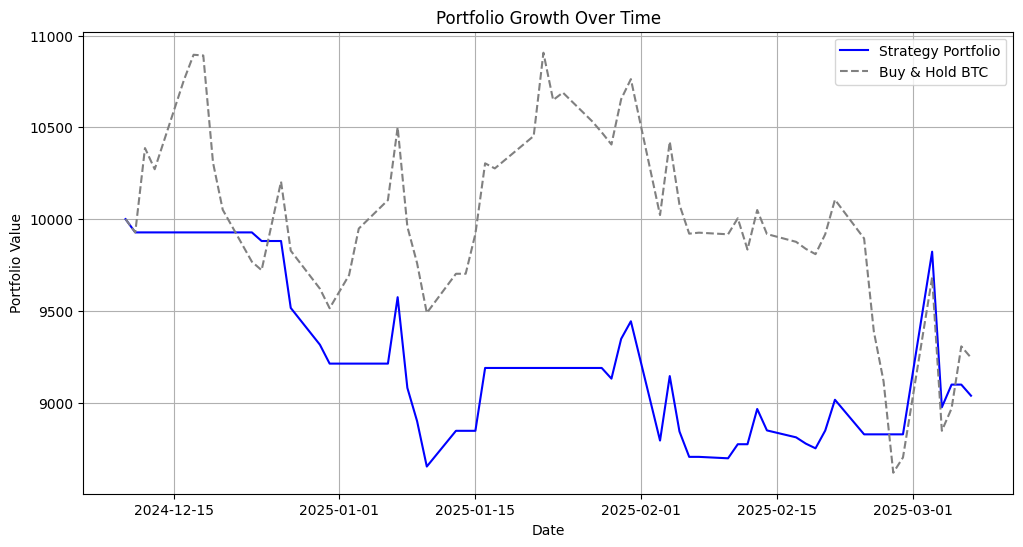

In [65]:
# Required Libraries
import pandas as pd
import numpy as np
import requests
import feedparser
import yfinance as yf
import tweepy
import time
import logging
import matplotlib.pyplot as plt
from transformers import pipeline

# ================================
#  🔹 SETUP LOGGING
# ================================
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# ================================
# 1️⃣ FETCH HISTORICAL GOLD PRICE DATA
# ================================
def fetch_gold_data():
    """Fetches historical gold price data from Yahoo Finance."""
    gold = yf.Ticker("GC=F")  # Gold futures symbol
    gold_df = gold.history(period="90d", interval="1d")  # 90 days of historical data
    gold_df = gold_df[["Close"]].rename(columns={"Close": "Gold_Price"})
    gold_df.index = gold_df.index.tz_localize(None)  # Ensure timezone-naive index
    return gold_df

gold_df = fetch_gold_data()
logging.info("✅ Gold Data Fetched:")
print(gold_df.head())

# ================================
# 2️⃣ FETCH HISTORICAL CRYPTO PRICE DATA FROM COINGECKO
# ================================
def fetch_crypto_data(symbol="bitcoin"):
    """Fetches historical cryptocurrency price data from CoinGecko."""
    url = f"https://api.coingecko.com/api/v3/coins/{symbol}/market_chart?vs_currency=usd&days=90&interval=daily"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['prices'], columns=["timestamp", "Crypto_Price"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit='ms')
    df.set_index("timestamp", inplace=True)
    df.index = df.index.tz_localize(None)  # Ensure timezone-naive index
    return df

crypto_df = fetch_crypto_data()
logging.info("✅ Crypto Price Data Fetched:")
print(crypto_df.head())

# ================================
# 3️⃣ MERGE GOLD AND CRYPTO DATA FOR BACKTESTING
# ================================
def merge_data():
    """Merges gold and crypto data into a single dataframe."""
    merged_df = gold_df.merge(crypto_df, left_index=True, right_index=True, how="inner")
    return merged_df

data = merge_data()
logging.info("✅ Merged Gold and Crypto Data:")
print(data.head())

# ================================
# 4️⃣ BACKTESTING FUNCTION WITH VISUALIZATION
# ================================
def backtest(data, initial_balance=10000):
    """Runs a backtest simulation using the sentiment-based strategy."""
    balance = initial_balance
    position = 0  # Tracks if we are holding an asset
    portfolio_values = []

    for date, row in data.iterrows():
        sentiment_score = np.random.uniform(-1, 1)  # Simulated sentiment data (Replace with historical sentiment data)
        signal = trading_strategy(sentiment_score)

        if signal == "📈 BUY Signal: Positive sentiment detected!" and balance > 0:
            position = balance / row["Crypto_Price"]  # Buy Crypto
            balance = 0  # Fully Invested
        elif signal == "📉 SELL Signal: Negative sentiment detected!" and position > 0:
            balance = position * row["Crypto_Price"]  # Sell Crypto
            position = 0  # Exit Position

        portfolio_value = balance + (position * row["Crypto_Price"])  # Total value
        portfolio_values.append(portfolio_value)

    # Convert portfolio values to DataFrame
    results_df = pd.DataFrame({"Portfolio Value": portfolio_values}, index=data.index)

    # Calculate total return
    total_return = (results_df.iloc[-1]["Portfolio Value"] - initial_balance) / initial_balance
    logging.info(f"✅ Backtest Completed. Total Return: {total_return:.2%}")

    # Plot portfolio growth
    plt.figure(figsize=(12, 6))
    plt.plot(results_df.index, results_df["Portfolio Value"], label="Strategy Portfolio", color='blue')
    plt.plot(data.index, initial_balance * (data["Crypto_Price"] / data["Crypto_Price"].iloc[0]), label="Buy & Hold BTC", linestyle='dashed', color='gray')
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.title("Portfolio Growth Over Time")
    plt.legend()
    plt.grid()
    plt.show()

    return total_return

# Run Backtest
backtest_return = backtest(data)
logging.info(f"📊 Backtest Return: {backtest_return:.2%}")